# Test trained model(s)

In [2]:
######################################
#Script to test and log trained model#
#Maintainer: Christopher Chan        #
#Version: 0.3.3                      #
#Date: 2022-04-26                    #
######################################

import os
import sys
import torch
import random
import re
import tqdm
from dataloader import BuildingDataset
import numpy as np
import torchvision.models as models
import segmentation_models_pytorch as smp
import torch.nn as nn
import matplotlib
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
from Networks import Five_UNet, Four_UNet
from torchvision import transforms
from PIL import Image
from scipy import ndimage
%matplotlib inline

device = (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))

print(f"Training on device {device}.")

data_path = os.path.abspath("/home/chris/Dropbox/HOTOSM/SAMPLE/")
Four_UNet = Four_UNet()

Training on device cpu.


In [3]:
TestIMG_ls = []
TestLBL_ls = []

for root, dirs, filename in os.walk(os.path.join(data_path, "Test_15cm", "IMG")):
    for i in filename:
        #if i.startswith("KBY15_IMG"):
            TestIMG_ls.append(root + "/" + i)

for i in TestIMG_ls:
    
    i = re.sub("IMG", "LBL", i, count = 2)
    TestLBL_ls.append(i)

Test = BuildingDataset(png_dir = TestIMG_ls,
                       lbl_dir = TestLBL_ls)

assert len(Test.png_dir) == len(Test.lbl_dir)

print("Concatenated TESTING images: {0} and labels pair: {0} :".format(len(Test.png_dir)))
for x, y in zip(Test.png_dir, Test.lbl_dir):
    print(f"Image: {x}", f"Label: {y}")


Concatenated TESTING images: 435 and labels pair: 435 :
Image: /home/chris/Dropbox/HOTOSM/SAMPLE/Test_15cm/IMG/DZKN15_IMG_6669-3249.png Label: /home/chris/Dropbox/HOTOSM/SAMPLE/Test_15cm/LBL/DZKN15_LBL_6669-3249.png
Image: /home/chris/Dropbox/HOTOSM/SAMPLE/Test_15cm/IMG/KBY15_IMG_28215-22059.png Label: /home/chris/Dropbox/HOTOSM/SAMPLE/Test_15cm/LBL/KBY15_LBL_28215-22059.png
Image: /home/chris/Dropbox/HOTOSM/SAMPLE/Test_15cm/IMG/DZK15_IMG_3420-5814.png Label: /home/chris/Dropbox/HOTOSM/SAMPLE/Test_15cm/LBL/DZK15_LBL_3420-5814.png
Image: /home/chris/Dropbox/HOTOSM/SAMPLE/Test_15cm/IMG/KBY15_IMG_8037-16416.png Label: /home/chris/Dropbox/HOTOSM/SAMPLE/Test_15cm/LBL/KBY15_LBL_8037-16416.png
Image: /home/chris/Dropbox/HOTOSM/SAMPLE/Test_15cm/IMG/KBY15_IMG_29241-22914.png Label: /home/chris/Dropbox/HOTOSM/SAMPLE/Test_15cm/LBL/KBY15_LBL_29241-22914.png
Image: /home/chris/Dropbox/HOTOSM/SAMPLE/Test_15cm/IMG/KBY15_IMG_29925-23256.png Label: /home/chris/Dropbox/HOTOSM/SAMPLE/Test_15cm/LBL/KBY15_

<class 'torch.Tensor'>


Text(0.5, 1.0, 'LBL')

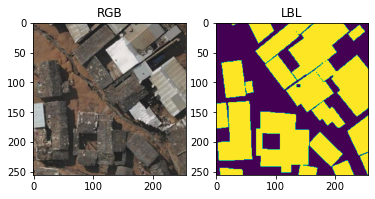

In [7]:
# plot a sample
test = BuildingDataset(TestIMG_ls, TestLBL_ls, transform = None)
test_pair = random.choice(test)

print(type(test_pair[0]))

fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
RGB = plt.imshow(test_pair[0].cpu().numpy().transpose(1, 2, 0))
ax.set_title('RGB')

ax = fig.add_subplot(1, 2, 2)
LBL = plt.imshow(test_pair[1].cpu().numpy().transpose(1, 2, 0))
ax.set_title('LBL')

### Vanilla Four layer U-Net Baseline

In [8]:
weights_4UNet = os.path.abspath(os.path.join(data_path, "best_weights", "BASE_15cmALL", "18242:3909_256oc_Four-Unet_lr1e-3_wd1e-5_b32_ep500_BCE_RLRonPlateau(min1e-8)_iter_280360.pth"))
weights_4UNet = torch.load(weights_4UNet, map_location = device)
Four_UNet.load_state_dict(weights_4UNet["Model:"])
Four_UNet.to(device = device)

print(sum(p.numel() for p in Four_UNet.parameters() if p.requires_grad == True))

7763041


torch.Size([3, 256, 256]) torch.Size([1, 256, 256])
Minimum: 6.696853233734146e-06, Maximum: 0.004634002689272165, Mean: 0.0021978975273668766, St dev: 0.0015041244914755225
True Positive = 36677, True Negative = 19672 False Negative = 1150, False Positive = 8037
Precision = 0.8202576637268066, Recall = 0.9695984125137329, Specificity = 0.7099498510360718 Overall Accuracy = 0.8598175048828125, Intersection-over-Union = 0.7996903657913208, Dice-Score = 0.8886977434158325


Text(0.5, 1.0, 'Binary Segmentation')

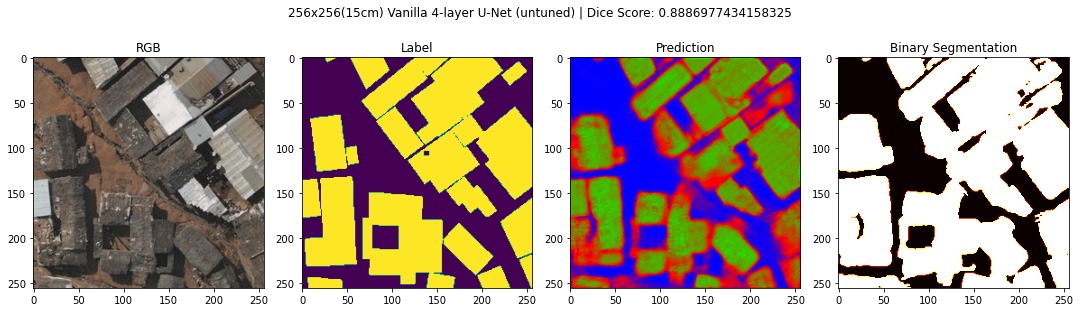

In [9]:
Four_UNet.eval()

# Testing a single pair of Image and Label

img, lbl = test_pair[0], test_pair[1]
img = img.to(device = device)
lbl = lbl.to(device = device)
print(img.shape, lbl.shape)

with torch.no_grad():
    prediction = Four_UNet(img.unsqueeze(0))
    prediction = prediction.squeeze(0)

    print("Minimum: {0}, Maximum: {1}, Mean: {2}, St dev: {3}".format(prediction.min(), prediction.max(), prediction.mean(), prediction.std()))

    pred_BOOL = (prediction > 0.001).to(torch.float32)
   
    # Booleanise
    pred_BOOL = pred_BOOL.bool()
    lbl = lbl.bool()

    # 1st order statistics
    TP = (pred_BOOL * lbl).sum(dim = [0, 1, 2])
    TN = ((~pred_BOOL) * (~lbl)).sum(dim = [0, 1, 2])
    FN = ((~pred_BOOL) * lbl).sum(dim = [0, 1, 2])
    FP = (pred_BOOL * (~lbl)).sum(dim = [0, 1, 2])

    # 2nd order statistics
    Precision = (TP / (TP + FP))
    Recall = (TP / (TP + FN)) #True Positive Rate / Sensitivity
    Specificity = (TN / (FP + TN)) #True Negative Rate
    OA = ((TP + TN) / (TP + TN + FP + FN))
    IoU = (TP / (TP + FN + FP))
    Dice = (2 * ((Precision * Recall) / (Precision + Recall)))

print("True Positive = {0}, True Negative = {1} False Negative = {2}, False Positive = {3}".format(TP, TN, FN, FP))
print("Precision = {0}, Recall = {1}, Specificity = {2} Overall Accuracy = {3}, Intersection-over-Union = {4}, Dice-Score = {5}".format(Precision, Recall, Specificity, OA, IoU, Dice))

# Plotting the RGB, Prediction, and Confidence
fig = plt.figure(figsize = (15, 5))
ax = fig.add_subplot(1, 4, 1)
fig.tight_layout(w_pad = 3)
fig.suptitle("256x256(15cm) Vanilla 4-layer U-Net (untuned) | Dice Score: {0}".format(Dice))
RGB = plt.imshow(test_pair[0].detach().cpu().numpy().transpose(1, 2, 0))
ax.set_title('RGB')

ax = fig.add_subplot(1, 4, 2)
PILlbl = lbl.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILlbl)
ax.set_title('Label')

ax = fig.add_subplot(1, 4, 3)
PILpred = prediction.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILpred, cmap = "brg")
#plt.colorbar(boundaries = np.arange(0, 1.0, 0.1), ticks = np.arange(0, 1.0, 0.1),
#             orientation = "horizontal")
ax.set_title('Prediction')

ax = fig.add_subplot(1, 4, 4)
PILbin = pred_BOOL.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILbin, cmap = "hot")
ax.set_title('Binary Segmentation')

### Qubvel OpenCities EB1-UNet

In [10]:
qubvelEB1_UNet = smp.Unet(encoder_name = 'efficientnet-b1', encoder_depth = 5, encoder_weights = None, decoder_use_batchnorm = True, decoder_channels = (256, 128, 64, 32, 16), decoder_attention_type = None, in_channels = 3, classes = 1, activation = "sigmoid", aux_params = None)
qubvel_weights = os.path.abspath("/home/chris/Dropbox/HOTOSM/qubvel_UNet/weights/stage3/effb1-f0/checkpoints/best.pth")
qubvel_weights = torch.load(qubvel_weights, map_location = device)
qubvelEB1_UNet.load_state_dict(qubvel_weights["state_dict"])
qubvelEB1_UNet.to(device = device)

print(sum(p.numel() for p in qubvelEB1_UNet.parameters() if p.requires_grad == True))

8757105


torch.Size([3, 256, 256]) torch.Size([1, 256, 256])
Minimum: 1.8674032462303127e-17, Maximum: 1.0, Mean: 0.1964978575706482, St dev: 0.39205747842788696
True Positive = 14261, True Negative = 27167 False Negative = 23566, False Positive = 542
Precision = 0.963385820388794, Recall = 0.37700584530830383, Specificity = 0.9804395437240601 Overall Accuracy = 0.63214111328125, Intersection-over-Union = 0.37168025970458984, Dice-Score = 0.5419343113899231


Text(0.5, 1.0, 'Binary Segmentation')

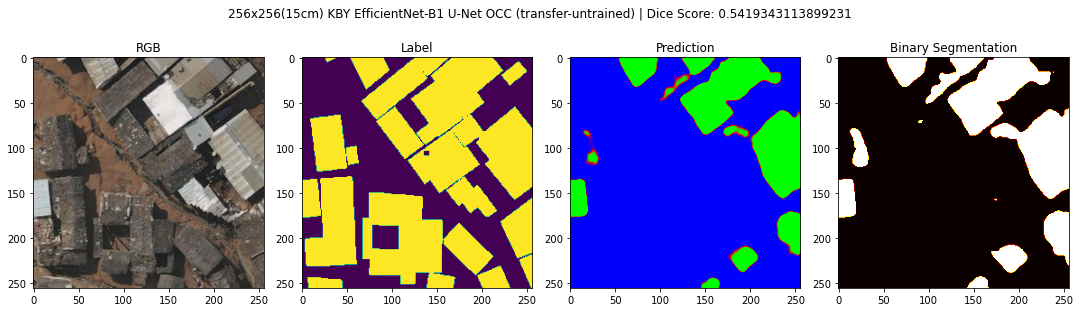

In [11]:
qubvelEB1_UNet.eval()

img, lbl = test_pair[0], test_pair[1]
img = img.to(device = device)
lbl = lbl.to(device = device)
print(img.shape, lbl.shape)

with torch.no_grad():
    prediction = qubvelEB1_UNet(img.unsqueeze(0))
    prediction = prediction.squeeze(0)

    print("Minimum: {0}, Maximum: {1}, Mean: {2}, St dev: {3}".format(prediction.min(), prediction.max(), prediction.mean(), prediction.std()))

    pred_BOOL = (prediction > 0.001).to(torch.float32)

    # Booleanise
    pred_BOOL = pred_BOOL.bool()
    lbl = lbl.bool()

    # 1st order statistics
    TP = (pred_BOOL * lbl).sum(dim = [0, 1, 2])
    TN = ((~pred_BOOL) * (~lbl)).sum(dim = [0, 1, 2])
    FN = ((~pred_BOOL) * lbl).sum(dim = [0, 1, 2])
    FP = (pred_BOOL * (~lbl)).sum(dim = [0, 1, 2])

    # 2nd order statistics
    Precision = (TP / (TP + FP))
    Recall = (TP / (TP + FN)) #True Positive Rate / Sensitivity
    Specificity = (TN / (FP + TN)) #True Negative Rate
    OA = ((TP + TN) / (TP + TN + FP + FN))
    IoU = (TP / (TP + FN + FP))
    Dice = (2 * ((Precision * Recall) / (Precision + Recall)))

print("True Positive = {0}, True Negative = {1} False Negative = {2}, False Positive = {3}".format(TP, TN, FN, FP))
print("Precision = {0}, Recall = {1}, Specificity = {2} Overall Accuracy = {3}, Intersection-over-Union = {4}, Dice-Score = {5}".format(Precision, Recall, Specificity, OA, IoU, Dice))

# Plotting the RGB, Prediction, and Confidence
fig = plt.figure(figsize = (15, 5))
ax = fig.add_subplot(1, 4, 1)
fig.tight_layout(w_pad = 3)
fig.suptitle("256x256(15cm) KBY EfficientNet-B1 U-Net OCC (transfer-untrained) | Dice Score: {0}".format(Dice))
RGB = plt.imshow(test_pair[0].detach().cpu().numpy().transpose(1, 2, 0))
ax.set_title('RGB')

ax = fig.add_subplot(1, 4, 2)
PILlbl = lbl.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILlbl)
ax.set_title('Label')

ax = fig.add_subplot(1, 4, 3)
PILpred = prediction.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILpred, cmap = "brg")
#plt.colorbar(boundaries = np.arange(0, 1.0, 0.1), ticks = np.arange(0, 1.0, 0.1),
#             orientation = "horizontal")
ax.set_title('Prediction')

ax = fig.add_subplot(1, 4, 4)
PILbin = pred_BOOL.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILbin, cmap = "hot")
ax.set_title('Binary Segmentation')

### EfficientNet B1-UNet Vanilla (No ImageNet) Baseline

In [12]:
EB1_UNet = smp.Unet(encoder_name = 'efficientnet-b1', encoder_depth = 4, encoder_weights = None, decoder_use_batchnorm = True, decoder_channels = (128, 64, 32, 16), decoder_attention_type = None, in_channels = 3, classes = 1, activation = "sigmoid", aux_params = None)

EB1_weights = os.path.abspath(os.path.join(data_path, "best_weights", "BASE_15cmALL", "18242:3909_256oc_EB1-Unet-NoIMN_lr1e-3_wd1e-5_b32_ep500_BCE_RLRonPlateau(min1e-8)_iter_160450.pth"))
EB1_weights = torch.load(EB1_weights, map_location = device)
EB1_UNet.load_state_dict(EB1_weights["Model:"])
EB1_UNet.to(device = device)

print(sum(p.numel() for p in EB1_UNet.parameters() if p.requires_grad == True))

7005041


torch.Size([3, 256, 256]) torch.Size([1, 256, 256])
Minimum: 3.137609496661753e-07, Maximum: 0.005441437009721994, Mean: 0.00205470179207623, St dev: 0.0014694787096232176
True Positive = 35882, True Negative = 21343 False Negative = 1945, False Positive = 6366
Precision = 0.8493183255195618, Recall = 0.9485816955566406, Specificity = 0.7702551484107971 Overall Accuracy = 0.8731842041015625, Intersection-over-Union = 0.8119385242462158, Dice-Score = 0.8962098360061646


Text(0.5, 1.0, 'Binary Segmentation')

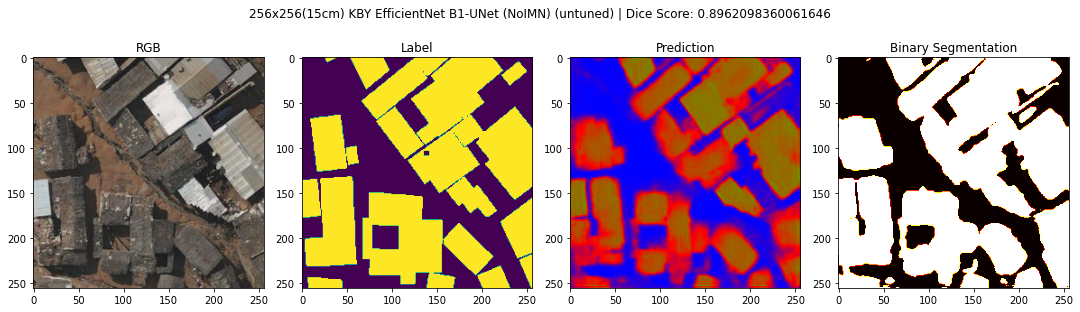

In [13]:
EB1_UNet.eval()

# Testing a single pair of Image and Label

img, lbl = test_pair[0], test_pair[1]
img = img.to(device = device)
lbl = lbl.to(device = device)
print(img.shape, lbl.shape)

with torch.no_grad():
    prediction = EB1_UNet(img.unsqueeze(0))
    prediction = prediction.squeeze(0)
    
    print("Minimum: {0}, Maximum: {1}, Mean: {2}, St dev: {3}".format(prediction.min(), prediction.max(), prediction.mean(), prediction.std()))

    pred_BOOL = (prediction > 0.001).to(torch.float32)

    # Booleanise
    pred_BOOL = pred_BOOL.bool()
    lbl = lbl.bool()

    # 1st order statistics
    TP = (pred_BOOL * lbl).sum(dim = [0, 1, 2])
    TN = ((~pred_BOOL) * (~lbl)).sum(dim = [0, 1, 2])
    FN = ((~pred_BOOL) * lbl).sum(dim = [0, 1, 2])
    FP = (pred_BOOL * (~lbl)).sum(dim = [0, 1, 2])

    # 2nd order statistics
    Precision = (TP / (TP + FP))
    Recall = (TP / (TP + FN)) #True Positive Rate / Sensitivity
    Specificity = (TN / (FP + TN)) #True Negative Rate
    OA = ((TP + TN) / (TP + TN + FP + FN))
    IoU = (TP / (TP + FN + FP))
    Dice = (2 * ((Precision * Recall) / (Precision + Recall)))

print("True Positive = {0}, True Negative = {1} False Negative = {2}, False Positive = {3}".format(TP, TN, FN, FP))
print("Precision = {0}, Recall = {1}, Specificity = {2} Overall Accuracy = {3}, Intersection-over-Union = {4}, Dice-Score = {5}".format(Precision, Recall, Specificity, OA, IoU, Dice))


# Plotting the RGB, Prediction, and Confidence
fig = plt.figure(figsize = (15, 5))
ax = fig.add_subplot(1, 4, 1)
fig.tight_layout(w_pad = 3)
fig.suptitle("256x256(15cm) KBY EfficientNet B1-UNet (NoIMN) (untuned) | Dice Score: {0}".format(Dice))
RGB = plt.imshow(test_pair[0].detach().cpu().numpy().transpose(1, 2, 0))
ax.set_title('RGB')

ax = fig.add_subplot(1, 4, 2)
PILlbl = lbl.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILlbl)
ax.set_title('Label')

ax = fig.add_subplot(1, 4, 3)
PILpred = prediction.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILpred, cmap = "brg")
#plt.colorbar(boundaries = np.arange(0, 1.0, 0.1), ticks = np.arange(0, 1.0, 0.1),
#             orientation = "horizontal")
ax.set_title('Prediction')

ax = fig.add_subplot(1, 4, 4)
PILbin = pred_BOOL.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILbin, cmap = "hot")
ax.set_title('Binary Segmentation')

### EfficientNet B1-UNet ImageNet (trained-untuned) Baseline

In [14]:
EB1_UNet_IMN = smp.Unet(encoder_name = 'efficientnet-b1', encoder_depth = 4, encoder_weights = None, decoder_use_batchnorm = True, decoder_channels = (128, 64, 32, 16), decoder_attention_type = None, in_channels = 3, classes = 1, activation = "sigmoid", aux_params = None)

IMN_weights = os.path.abspath(os.path.join(data_path, "best_weights", "BASE_15cmALL", "18242:3909_256oc_EB1-Unet-IMN_lr1e-3_wd1e-5_b32_ep500_BCE_RLRonPlateau(min1e-8)_iter_223260.pth"))
IMN_weights = torch.load(IMN_weights, map_location = device)
EB1_UNet_IMN.load_state_dict(IMN_weights["Model:"])
EB1_UNet_IMN.to(device = device)

print(sum(p.numel() for p in EB1_UNet_IMN.parameters() if p.requires_grad == True))

7005041


torch.Size([3, 256, 256]) torch.Size([1, 256, 256])
Minimum: 1.5791556506883353e-06, Maximum: 0.011212171986699104, Mean: 0.002097552642226219, St dev: 0.0014807601692155004
True Positive = 36354, True Negative = 21078 False Negative = 1473, False Positive = 6631
Precision = 0.8457368612289429, Recall = 0.9610595703125, Specificity = 0.7606914639472961 Overall Accuracy = 0.8763427734375, Intersection-over-Union = 0.817715585231781, Dice-Score = 0.8997178673744202


Text(0.5, 1.0, 'Binary Segmentation')

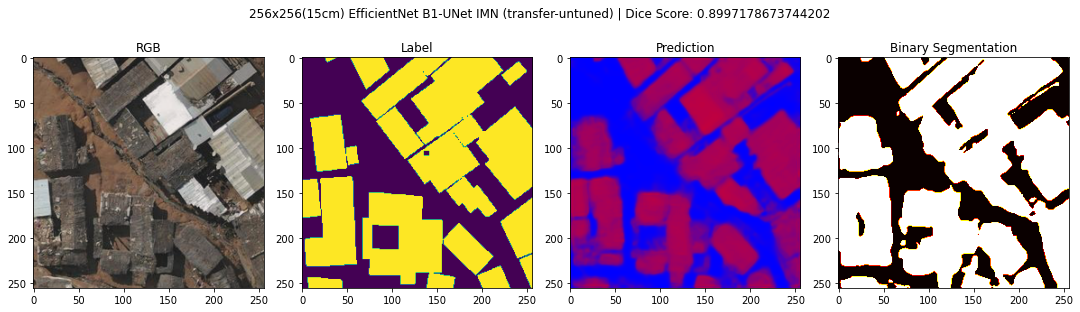

In [15]:
EB1_UNet_IMN.eval()

# Testing a single pair of Image and Label

img, lbl = test_pair[0], test_pair[1]
img = img.to(device = device)
lbl = lbl.to(device = device)
print(img.shape, lbl.shape)

with torch.no_grad():
    prediction = EB1_UNet_IMN(img.unsqueeze(0))
    prediction = prediction.squeeze(0)
    
    print("Minimum: {0}, Maximum: {1}, Mean: {2}, St dev: {3}".format(prediction.min(), prediction.max(), prediction.mean(), prediction.std()))

    pred_BOOL = (prediction > 0.001).to(torch.float32)

    # Booleanise
    pred_BOOL = pred_BOOL.bool()
    lbl = lbl.bool()

    # 1st order statistics
    TP = (pred_BOOL * lbl).sum(dim = [0, 1, 2])
    TN = ((~pred_BOOL) * (~lbl)).sum(dim = [0, 1, 2])
    FN = ((~pred_BOOL) * lbl).sum(dim = [0, 1, 2])
    FP = (pred_BOOL * (~lbl)).sum(dim = [0, 1, 2])

    # 2nd order statistics
    Precision = (TP / (TP + FP))
    Recall = (TP / (TP + FN)) #True Positive Rate / Sensitivity
    Specificity = (TN / (FP + TN)) #True Negative Rate
    OA = ((TP + TN) / (TP + TN + FP + FN))
    IoU = (TP / (TP + FN + FP))
    Dice = (2 * ((Precision * Recall) / (Precision + Recall)))

print("True Positive = {0}, True Negative = {1} False Negative = {2}, False Positive = {3}".format(TP, TN, FN, FP))
print("Precision = {0}, Recall = {1}, Specificity = {2} Overall Accuracy = {3}, Intersection-over-Union = {4}, Dice-Score = {5}".format(Precision, Recall, Specificity, OA, IoU, Dice))

# Plotting the RGB, Prediction, and Confidence
fig = plt.figure(figsize = (15, 5))
ax = fig.add_subplot(1, 4, 1)
fig.tight_layout(w_pad = 3)
fig.suptitle("256x256(15cm) EfficientNet B1-UNet IMN (transfer-untuned) | Dice Score: {0}".format(Dice))
RGB = plt.imshow(test_pair[0].detach().cpu().numpy().transpose(1, 2, 0))
ax.set_title('RGB')

ax = fig.add_subplot(1, 4, 2)
PILlbl = lbl.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILlbl)
ax.set_title('Label')

ax = fig.add_subplot(1, 4, 3)
PILpred = prediction.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILpred, cmap = "brg")
#plt.colorbar(boundaries = np.arange(0, 1.0, 0.1), ticks = np.arange(0, 1.0, 0.1),
#             orientation = "horizontal")
ax.set_title('Prediction')

ax = fig.add_subplot(1, 4, 4)
PILbin = pred_BOOL.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILbin, cmap = "hot")
ax.set_title('Binary Segmentation')

### EfficientNet B1-UNet OCC (transfer-trained) Baseline

In [16]:
EB1_UNet_OCCtrans = smp.Unet(encoder_name = 'efficientnet-b1', encoder_depth = 5, encoder_weights = None, decoder_use_batchnorm = True, decoder_channels = (256, 128, 64, 32, 16), decoder_attention_type = None, in_channels = 3, classes = 1, activation = "sigmoid", aux_params = None)

OCCtrans_weights = os.path.abspath(os.path.join(data_path, "best_weights", "BASE_15cmALL", "18242:3909_256oc_EB1-Unet-qubvel_lr1e-3_wd1e-5_b16_ep500_BCE_RLRonPlateau(min1e-8)_iter_548820.pth"))
OCCtrans_weights = torch.load(OCCtrans_weights, map_location = device)
EB1_UNet_OCCtrans.load_state_dict(OCCtrans_weights["Model:"])
EB1_UNet_OCCtrans.to(device = device)

print(sum(p.numel() for p in EB1_UNet_OCCtrans.parameters() if p.requires_grad == True))

8757105


torch.Size([3, 256, 256]) torch.Size([1, 256, 256])
Minimum: 1.5597414630974527e-06, Maximum: 0.006811772473156452, Mean: 0.0018913070671260357, St dev: 0.0014176819240674376
True Positive = 35458, True Negative = 21980 False Negative = 2369, False Positive = 5729
Precision = 0.860902726650238, Recall = 0.9373728036880493, Specificity = 0.7932440638542175 Overall Accuracy = 0.876434326171875, Intersection-over-Union = 0.8140784502029419, Dice-Score = 0.897511899471283


Text(0.5, 1.0, 'Binary Segmentation')

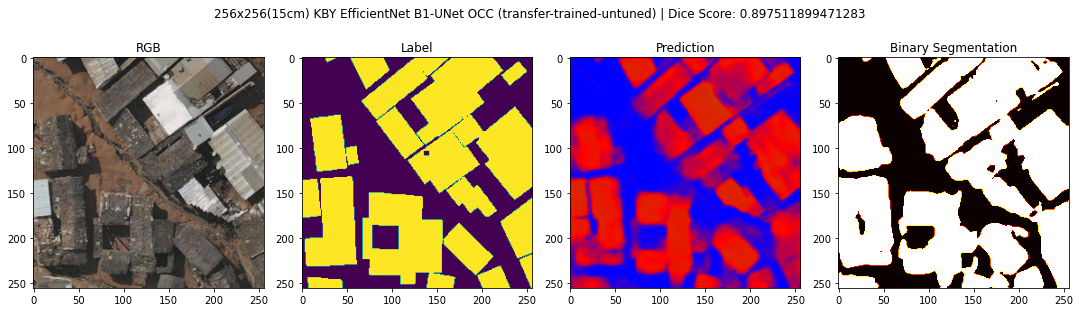

In [17]:
EB1_UNet_OCCtrans.eval()

# Testing a single pair of Image and Label

img, lbl = test_pair[0], test_pair[1]
img = img.to(device = device)
lbl = lbl.to(device = device)
print(img.shape, lbl.shape)

with torch.no_grad():
    prediction = EB1_UNet_OCCtrans(img.unsqueeze(0))
    prediction = prediction.squeeze(0)
    
    print("Minimum: {0}, Maximum: {1}, Mean: {2}, St dev: {3}".format(prediction.min(), prediction.max(), prediction.mean(), prediction.std()))

    pred_BOOL = (prediction > 0.001).to(torch.float32)

    # Booleanise
    pred_BOOL = pred_BOOL.bool()
    lbl = lbl.bool()

    # 1st order statistics
    TP = (pred_BOOL * lbl).sum(dim = [0, 1, 2])
    TN = ((~pred_BOOL) * (~lbl)).sum(dim = [0, 1, 2])
    FN = ((~pred_BOOL) * lbl).sum(dim = [0, 1, 2])
    FP = (pred_BOOL * (~lbl)).sum(dim = [0, 1, 2])

    # 2nd order statistics
    Precision = (TP / (TP + FP))
    Recall = (TP / (TP + FN)) #True Positive Rate / Sensitivity
    Specificity = (TN / (FP + TN)) #True Negative Rate
    OA = ((TP + TN) / (TP + TN + FP + FN))
    IoU = (TP / (TP + FN + FP))
    Dice = (2 * ((Precision * Recall) / (Precision + Recall)))

print("True Positive = {0}, True Negative = {1} False Negative = {2}, False Positive = {3}".format(TP, TN, FN, FP))
print("Precision = {0}, Recall = {1}, Specificity = {2} Overall Accuracy = {3}, Intersection-over-Union = {4}, Dice-Score = {5}".format(Precision, Recall, Specificity, OA, IoU, Dice))

# Plotting the RGB, Prediction, and Confidence
fig = plt.figure(figsize = (15, 5))
ax = fig.add_subplot(1, 4, 1)
fig.tight_layout(w_pad = 3)
fig.suptitle("256x256(15cm) KBY EfficientNet B1-UNet OCC (transfer-trained-untuned) | Dice Score: {0}".format(Dice))
RGB = plt.imshow(test_pair[0].detach().cpu().numpy().transpose(1, 2, 0))
ax.set_title('RGB')

ax = fig.add_subplot(1, 4, 2)
PILlbl = lbl.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILlbl)
ax.set_title('Label')

ax = fig.add_subplot(1, 4, 3)
PILpred = prediction.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILpred, cmap = "brg")
#plt.colorbar(boundaries = np.arange(0, 1.0, 0.1), ticks = np.arange(0, 1.0, 0.1),
#             orientation = "horizontal")
ax.set_title('Prediction')

ax = fig.add_subplot(1, 4, 4)
PILbin = pred_BOOL.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILbin, cmap = "hot")
ax.set_title('Binary Segmentation')